### Preprocessing bullseye few-tilt precession data


Example of data processing for dataset acquired with bullseye aperatures, where it is necessary to convert 4D-STEM data to BraggVectors to find the central spot. 

---

''Multi-angle precession electron diffraction (MAPED): a versatile approach to 4D-STEM precession''

Stephanie M. Ribet [1], Rohan Dhall [1], Colin Ophus [2], Karen C. Bustillo [1]

[1] National Center for Electron Microscopy, Molecular Foundry, Lawrence Berkeley National Laboratory

[2] Department of Materials Science and Engineering, Stanford University


In [1]:
import numpy as np
import py4DSTEM
from emdfile import tqdmnd
import matplotlib.pyplot as plt
from skimage.registration import phase_cross_correlation

cupyx.jit.rawkernel is experimental. The interface can change in the future.


### define file paths

In [2]:
data_path = ''
file_path_0 = data_path + 'magical_23_master.h5' # tilt 0
file_path_1 = data_path + 'magical_24_master.h5' # tilt 1
file_path_2 = data_path + 'magical_26_master.h5' # tilt 2
file_path_3 = data_path + 'magical_27_master.h5' # tilt 3
file_path_4 = data_path + 'magical_28_master.h5' # tilt 4
file_path_c = data_path + 'magical_29_master.h5' # control scan

### load and pre-process first dataset

In [3]:
dc0 = py4DSTEM.import_file(file_path_0)

Dataset is uint32 but will be converted to uint16


In [4]:
dc0.get_dp_mean()

VirtualDiffraction( A 2-dimensional array of shape (192, 192) called 'dp_mean',
                    with dimensions:

                        dim0 = [0,1,2,...] pixels
                        dim1 = [0,1,2,...] pixels
)

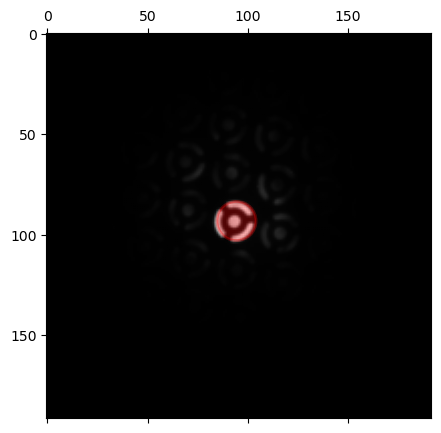

In [5]:
# find probe size
probe_semiangle, probe_qx0, probe_qy0 = dc0.get_probe_size(
    plot = True,
    thresh_upper=0.18 #this value needs to be low for bullseye data
)

In [6]:
dc0.get_virtual_image(
    geometry = ((0,0), (probe_semiangle + 5,50)),
    mode = "annular",
    name = "DF",
    centered = True
    
)

100%|██████████████████████████████████| 36864/36864 [00:00<00:00, 49142.22it/s]


VirtualImage( A 2-dimensional array of shape (192, 192) called 'DF',
              with dimensions:

                  dim0 = [0,1,2,...] pixels
                  dim1 = [0,1,2,...] pixels
)

In [7]:
# pick points for disk detection 

rxs = np.arange(6) * 20 + 40
rys = np.arange(6) * 20 + 4

colors=['r','limegreen','c','g','orange', 'violet']

py4DSTEM.visualize.show_points(
    dc0.tree('DF'),
    x=rxs,
    y=rys,
    pointcolor=colors,
)


In [8]:
# define vacuum probe region from scan area over vacuum
# could also be a separate 4D-STEM scan if there is no vacuum region in FOV
dc_probe = dc0.copy().crop_R((0,25,150,175)) 

100%|████████████████████████████████████████| 624/624 [00:01<00:00, 406.90it/s]


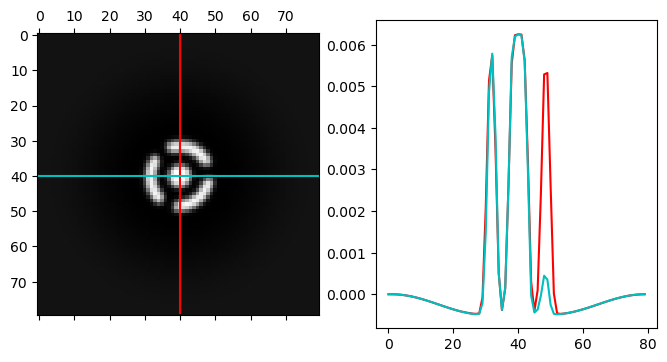

In [9]:
# make vacuum probe
probe_align = dc_probe.get_vacuum_probe(
    plot = False,
    zero_vacuum=False
)

# Construct a probe template to use as a kernel for correlation disk detection
probe_kernel = probe_align.get_kernel(
    mode = 'sigmoid',
    radii = (probe_semiangle * 1.0, probe_semiangle * 4.0),
    bilinear=True,
)

# Plot the probe kernel
py4DSTEM.visualize.show_kernel(
    probe_align.kernel, 
    R=40, 
    L=40, 
    W=1,
    figsize = (8,4),
)


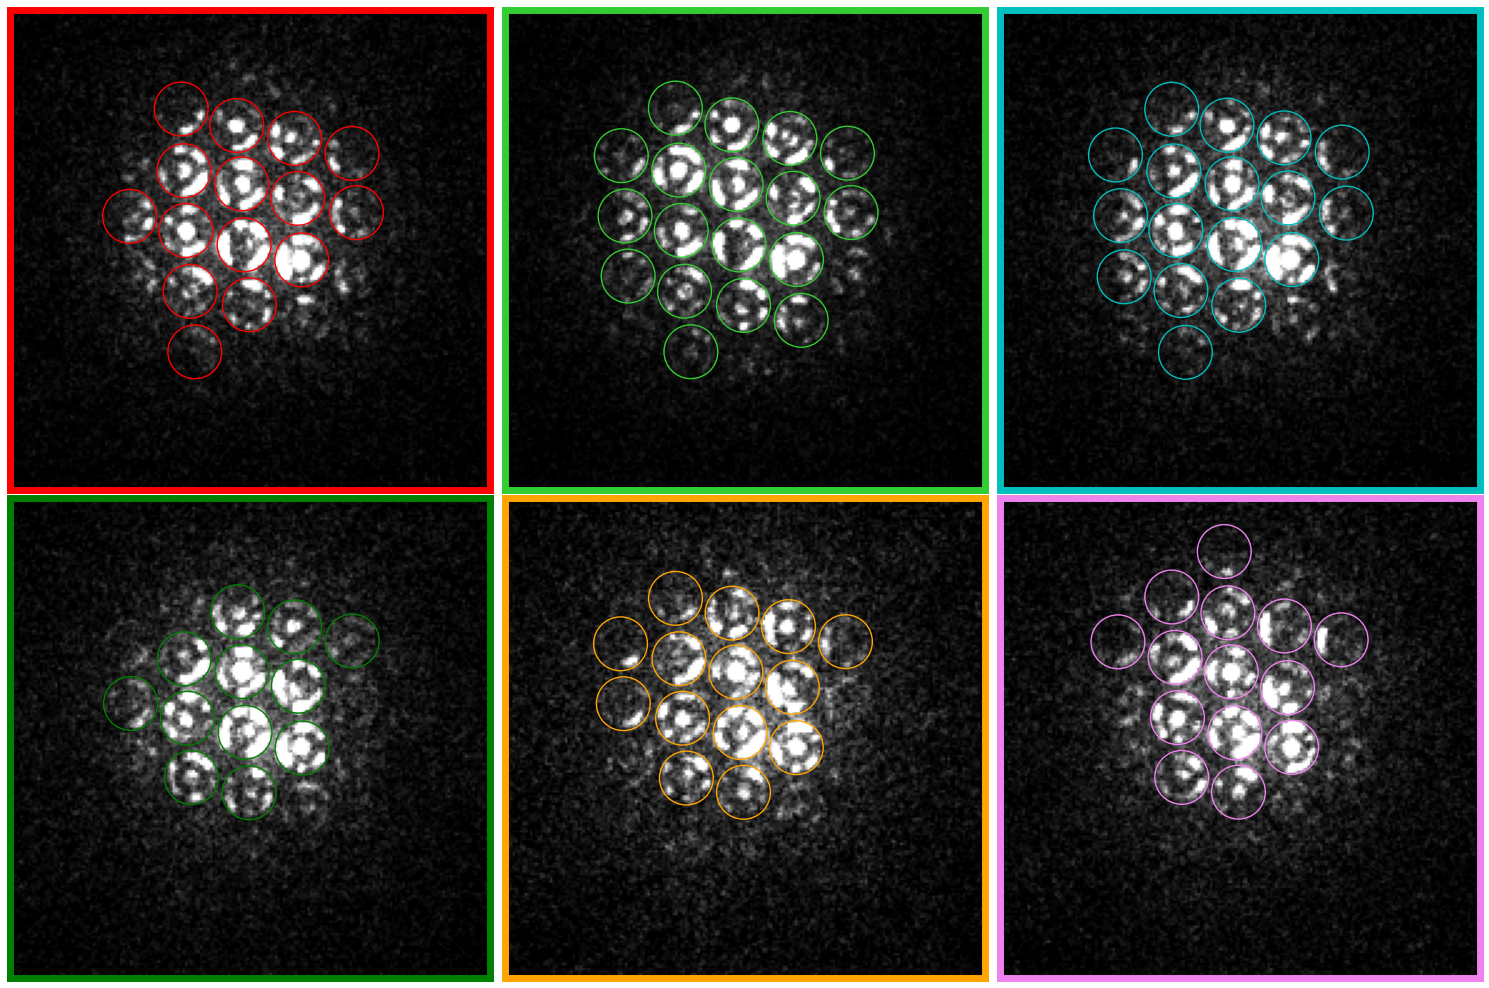

In [10]:
# perform dist detection, tune hyper-parameters
detect_params = {
    'corrPower': 1.0,
    'sigma': 0,
    'edgeBoundary': 2,
    'minRelativeIntensity': 0,
    'minAbsoluteIntensity': 1,
    'minPeakSpacing': probe_semiangle * 2,
    'subpixel' : 'poly',
#     'subpixel' : 'multicorr',
    'upsample_factor': 8,
    'maxNumPeaks': 1000,
#     'CUDA': True,
}

disks_selected = dc0.find_Bragg_disks(
    data = (rxs, rys),
    template = probe_kernel,
    **detect_params,
)

py4DSTEM.visualize.show_image_grid(
    get_ar = lambda i:dc0.data[rxs[i],rys[i],:,:],
    H=2, 
    W=3,
    axsize=(5,5),
    get_bordercolor = lambda i:colors[i],
    get_x = lambda i: disks_selected[i].data['qx'],
    get_y = lambda i: disks_selected[i].data['qy'],
    get_pointcolors = lambda i: colors[i],
    open_circles = True,
    scale = 1500,
)


In [11]:
#run disk detection on entire dataset
bragg_peaks = dc0.find_Bragg_disks(
    template = probe_kernel,
    **detect_params,
)    

Finding Bragg Disks: 100%|██████████████████| 36.9k/36.9k [00:55<00:00, 660DP/s]


In [12]:
# calculate bvm
bvm_raw = bragg_peaks.histogram(mode = 'raw')

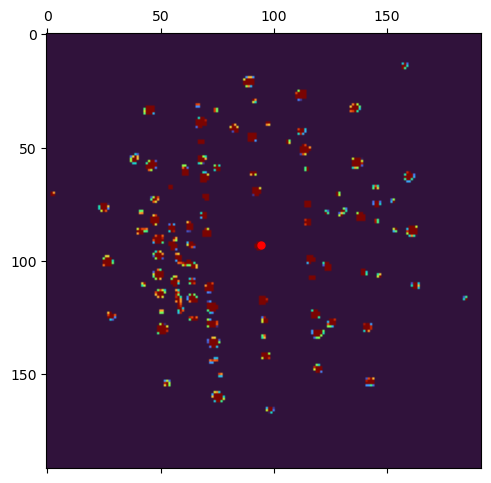

In [13]:
# provide center guess based on previous calculated center
center_guess = probe_qx0, probe_qy0

py4DSTEM.show(
    bvm_raw,
    points = {'x':center_guess[0],'y':center_guess[1]},
    power = 0.5,
    cmap = "turbo"
)


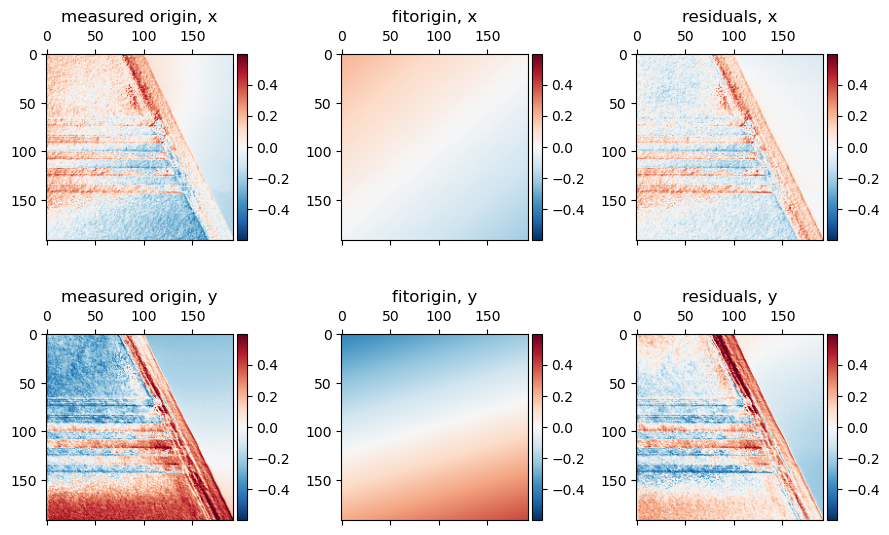

In [14]:
# measure origin
origin_meas = bragg_peaks.measure_origin( center_guess=center_guess )
# fit a 2D plane
qx0_fit,qy0_fit,qx0_residuals,qy0_residuals = bragg_peaks.fit_origin()



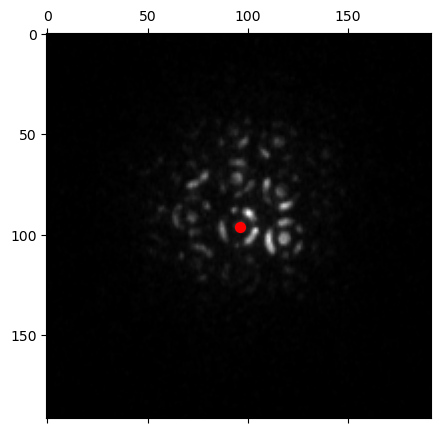

In [15]:
#check center finding
py4DSTEM.visualize.show_points(
    py4DSTEM.process.utils.get_shifted_ar(
        dc0[0,0],
        xshift=(dc0.Qshape[0]/2 - qx0_fit[0,0]),
        yshift=(dc0.Qshape[1]/2 - qy0_fit[0,0]),
        bilinear=True
    ),
    vmax =1,
    x =dc0.Qshape[0]/2,
    y = dc0.Qshape[1]/2
    
)

In [16]:
dc0.data = np.asarray(dc0.data, dtype = "float")

In [17]:
#align data
for a0 in range(dc0.Rshape[0]):
    for a1 in range(dc0.Rshape[1]): 
        dc0.data[a0,a1] = py4DSTEM.process.utils.get_shifted_ar(
            dc0.data[a0,a1],
            xshift=(dc0.Qshape[0]/2 - qx0_fit[a0,a1]),
            yshift=(dc0.Qshape[1]/2 - qy0_fit[a0,a1]),
            bilinear=True
        )

### center the rest of the datasets with function

In [19]:
def load_and_center_datacube(
    file_path,
    pad = False,
    bin_factor_R = 1,
    bin_factor_Q = 1,
):
    """
    Function for loading and centering 4D-STEM datasets

    Parameters
    ----------
    file_path: str
        location of dataset to import
    pad: bool
        If True, pads before shiting diffraction data
    bin_factor_R: int
        binning factor in real space
    bin_factor_Q: int
        binning factor in reciprocal space

    Returns
    -------
    py4DTEM DataCube with 4D-STEM data diffraction space centered
    """
    # load data
    # change import_file to load_file if already a py4DSTEM datacube
    dc1 = py4DSTEM.import_file(file_path).bin_Q(bin_factor_Q).bin_R(bin_factor_R)
    dc1.get_dp_mean()

    # get estimate for center
    _, probe_qx1, probe_qy1 = dc1.get_probe_size(
        plot = True,
        thresh_upper=0.12
    )

    # find bragg disks using the parameters optimized above
    bragg_peaks = dc1.find_Bragg_disks(
        template = probe_kernel,
        **detect_params,
    )

    # measure and fit origin 
    origin_meas = bragg_peaks.measure_origin( center_guess=(probe_qx1, probe_qy1) )
    qx0_fit,qy0_fit,qx0_residuals,qy0_residuals = bragg_peaks.fit_origin()

    # pad data if necessary
    if pad == True: 
        shifts_x = dc1.Qshape[0]/2 - qx0_fit
        shifts_y = dc1.Qshape[1]/2 - qy0_fit
        pad_width = int(np.max((np.abs(shifts_x), np.abs(shifts_y))))
        dc1.data = np.pad(dc1.data, ((0,0), (0,0), (pad_width, pad_width), (pad_width, pad_width)))

    else: 
        pad_width = 0
    
    # center data with bilinear interpolation
    dc1.data = np.asarray(dc1.data, dtype = "float")
    for a0, a1 in tqdmnd(
        dc1.Rshape[0],
        dc1.Rshape[1],
        desc="aligning",
        unit="DP",
        unit_scale=True,
    ):
        dc1.data[a0,a1] = py4DSTEM.process.utils.get_shifted_ar(
            dc1.data[a0,a1],
            xshift=(dc1.Qshape[0]/2 - qx0_fit[a0,a1]-pad_width),
            yshift=(dc1.Qshape[1]/2 - qy0_fit[a0,a1]-pad_width),
            bilinear=True
        )
    return dc1

         

Dataset is uint32 but will be converted to uint16


Finding Bragg Disks: 100%|██████████████████| 36.9k/36.9k [00:58<00:00, 627DP/s]
aligning: 100%|███████████████████████████| 36.9k/36.9k [00:07<00:00, 4.98kDP/s]


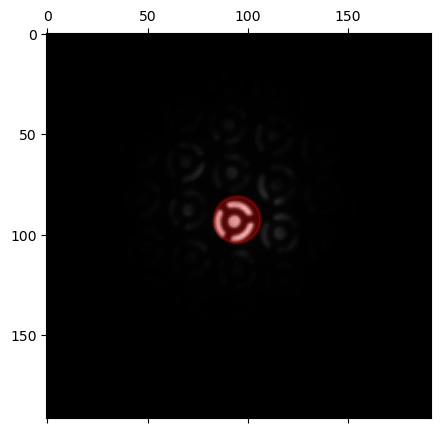

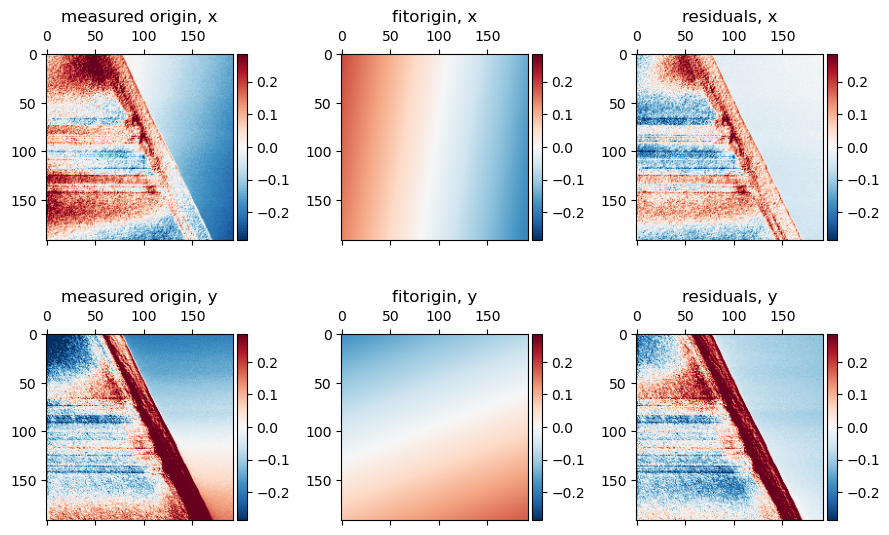

In [20]:
# check function on scan #1
dc1 =load_and_center_datacube(file_path_1) 

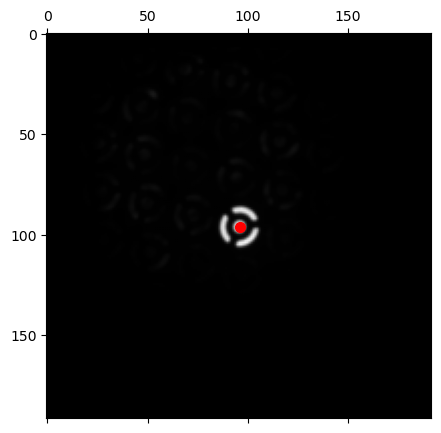

In [21]:
py4DSTEM.visualize.show_points(
    dc1.data.mean((0,1)),
    vmax =1,
    x = dc1.Qshape[0]/2,
    y = dc1.Qshape[1]/2,
    
)

Dataset is uint32 but will be converted to uint16


Finding Bragg Disks: 100%|██████████████████| 36.9k/36.9k [00:59<00:00, 621DP/s]
aligning: 100%|███████████████████████████| 36.9k/36.9k [00:07<00:00, 4.67kDP/s]


Dataset is uint32 but will be converted to uint16


Finding Bragg Disks: 100%|██████████████████| 36.9k/36.9k [01:01<00:00, 599DP/s]
aligning: 100%|███████████████████████████| 36.9k/36.9k [00:07<00:00, 5.12kDP/s]


Dataset is uint32 but will be converted to uint16


Finding Bragg Disks: 100%|██████████████████| 36.9k/36.9k [00:56<00:00, 656DP/s]
aligning: 100%|███████████████████████████| 36.9k/36.9k [00:07<00:00, 4.70kDP/s]


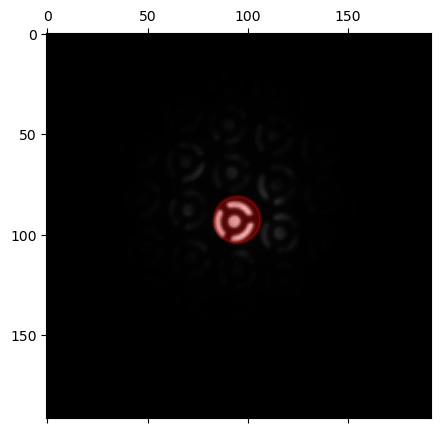

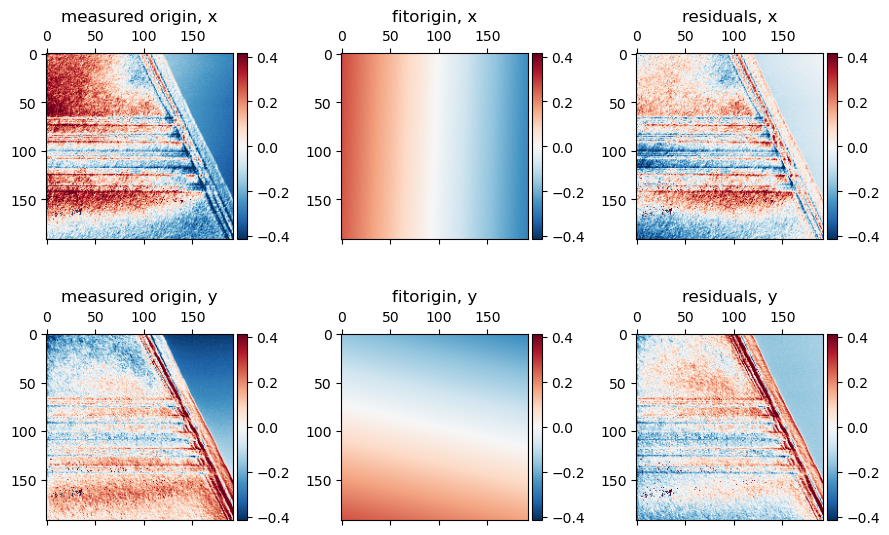

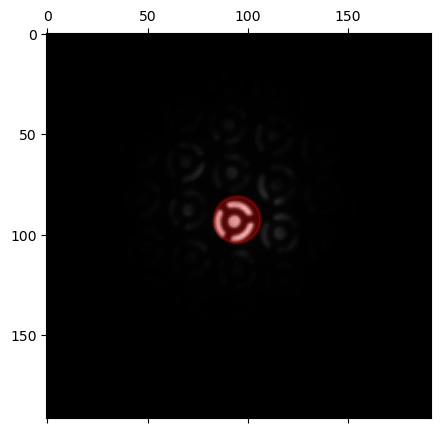

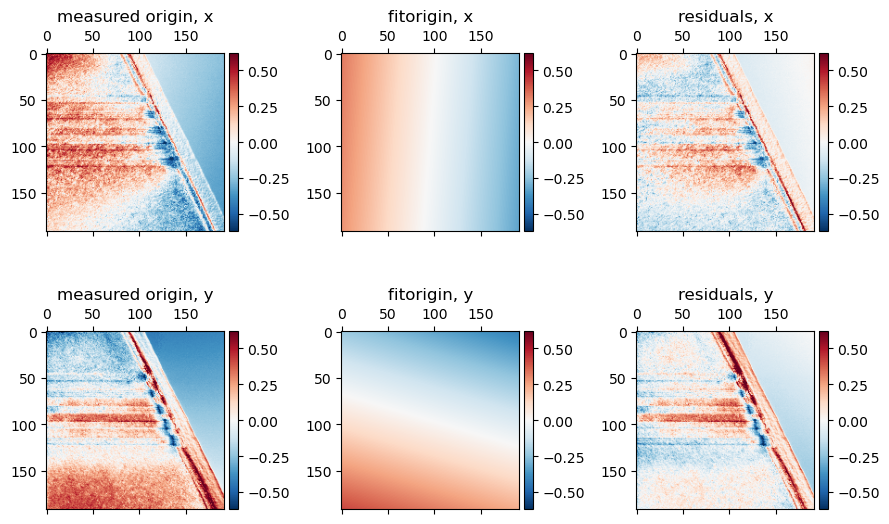

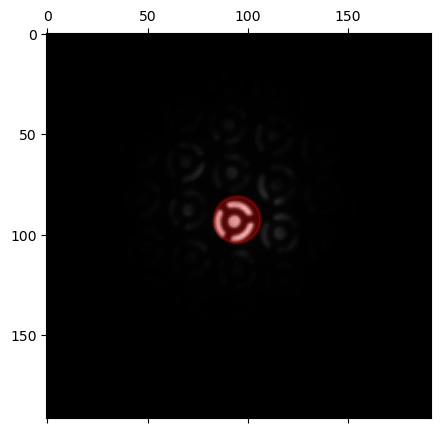

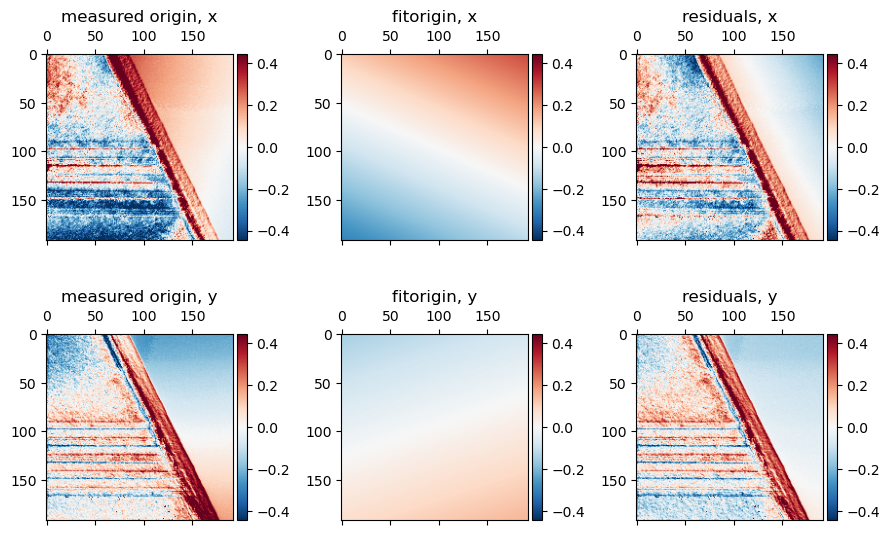

In [22]:
# load and process remaining scans
dc2 =load_and_center_datacube(file_path_2)
dc3 =load_and_center_datacube(file_path_3)
dc4 =load_and_center_datacube(file_path_4)


### make virtual images and mean diffraction patterns

100%|██████████████████████████████████| 36864/36864 [00:01<00:00, 28523.11it/s]


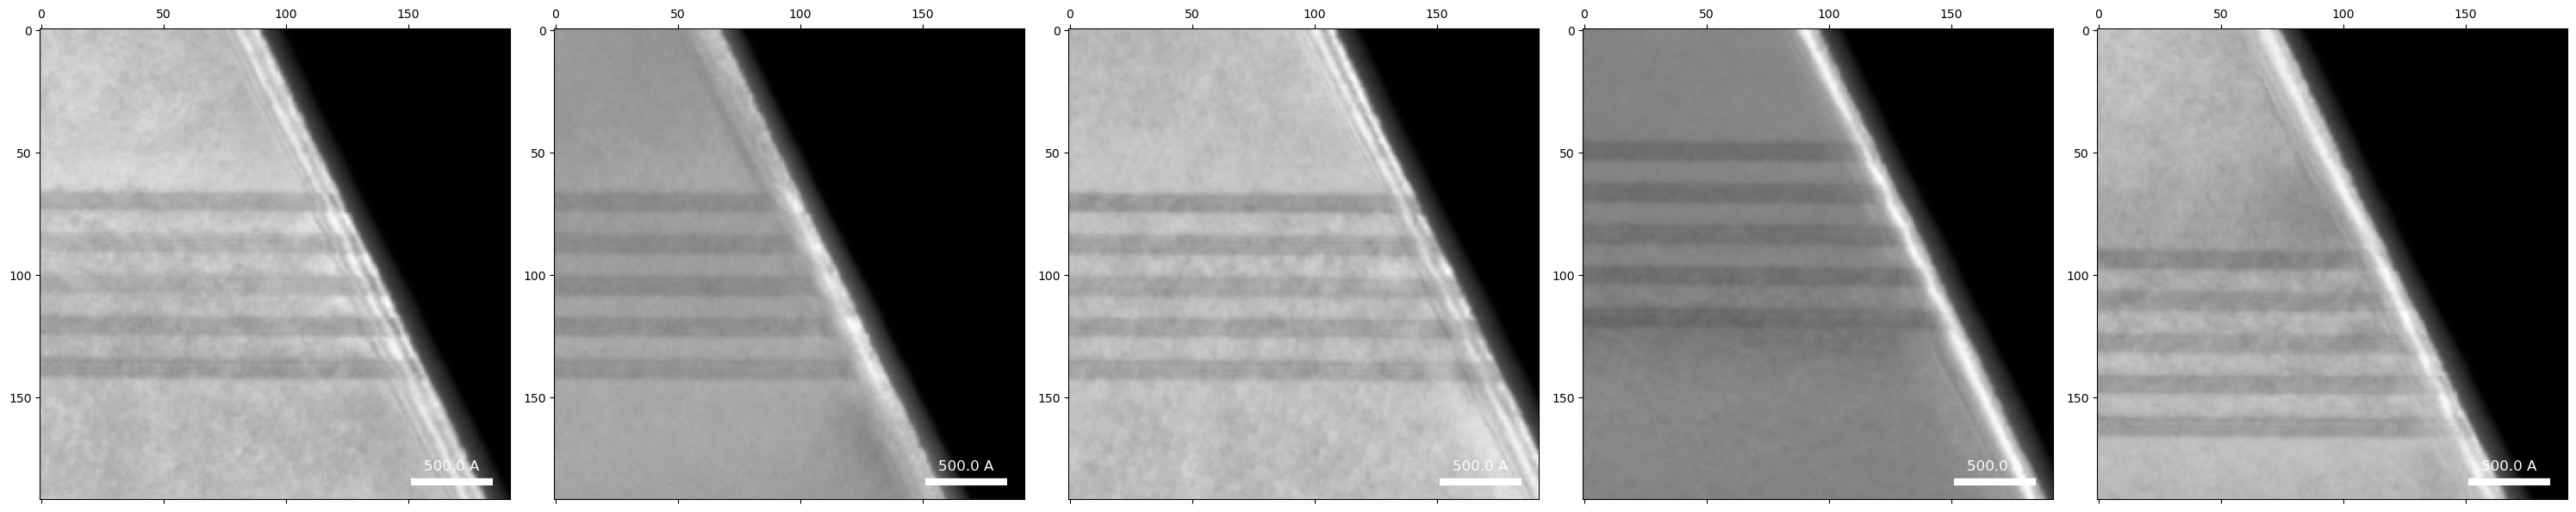

In [23]:

geometry = ((77,75), probe_semiangle+5)
mode = "circular"
name = "DF"


geometry = ((96,96), (probe_semiangle + 2, (probe_semiangle + 5) * 3))
mode = "annular"




dc0.get_virtual_image(
    geometry = geometry,
    mode = mode,
    name = name 
)

dc1.get_virtual_image(
    geometry = geometry,
    mode = mode,
    name = name 
    
)
dc2.get_virtual_image(
    geometry = geometry,
    mode = mode,
    name = name 
    
)
dc3.get_virtual_image(
    geometry = geometry,
    mode = mode,
    name = name 
    
)
dc4.get_virtual_image(
    geometry = geometry,
    mode = mode,
    name = name 
    
)

py4DSTEM.show(
    [
        dc0.tree('DF'),
        dc1.tree('DF'),
        dc2.tree('DF'),
        dc3.tree('DF'),
        dc4.tree('DF'),
        
    ],
    vmax =1,
    vmin = 0
    
)

In [34]:
dc0.get_dp_mean()
dc1.get_dp_mean()
dc2.get_dp_mean()
dc3.get_dp_mean()
dc4.get_dp_mean()

VirtualDiffraction( A 2-dimensional array of shape (192, 192) called 'dp_mean',
                    with dimensions:

                        dim0 = [0,1,2,...] pixels
                        dim1 = [0,1,2,...] pixels
)

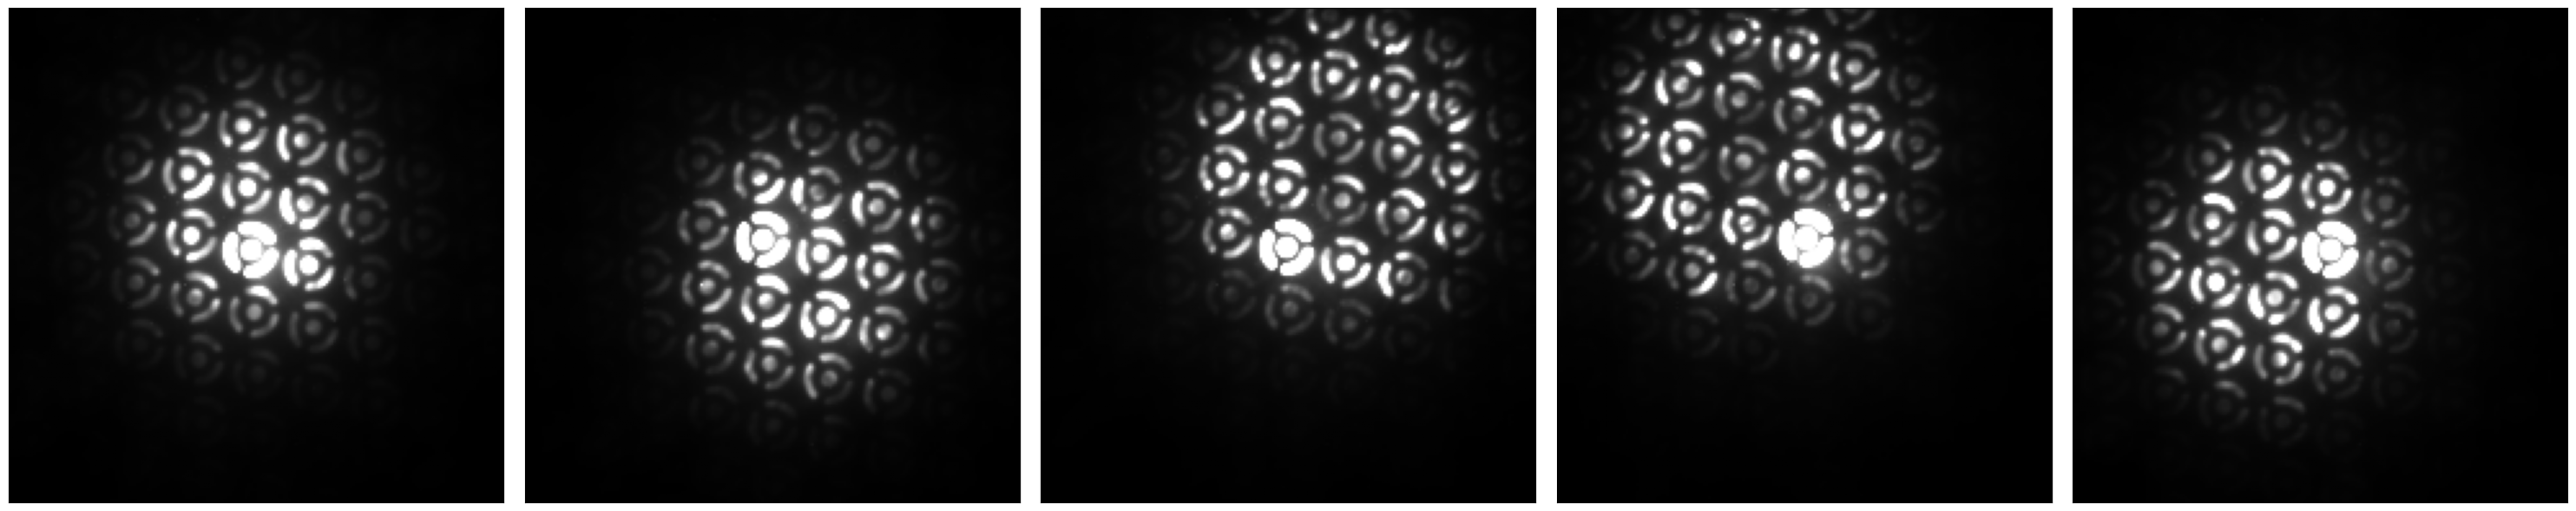

In [24]:
fig, ax = py4DSTEM.show(
    [
        dc0.tree('dp_mean'),
        dc2.tree('dp_mean'),
        dc3.tree('dp_mean'),
        dc1.tree('dp_mean'),
        dc4.tree('dp_mean')
        
    ],
    ticks = False,
    scalebar = False,
    returnfig=True
)

plt.tight_layout()
# plt.savefig('DPs.pdf', bbox_inches = "tight")


### combine datasets



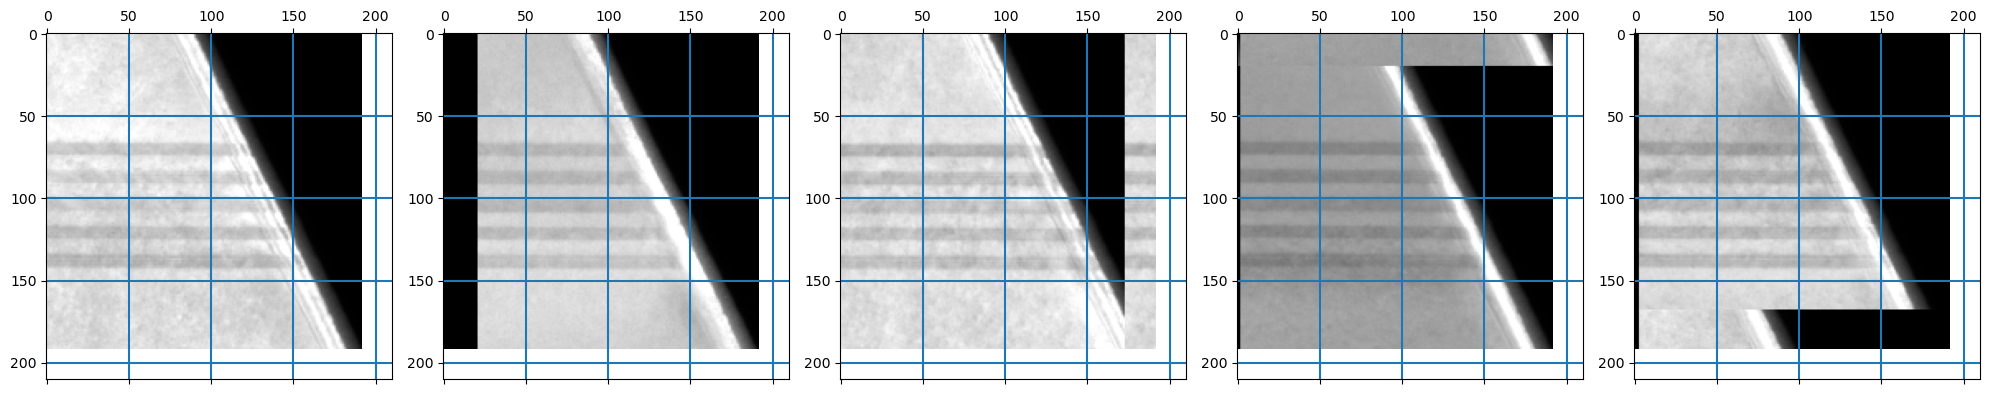

In [25]:
# use cross-correlation to align bright field images.

shifts = np.zeros((5,2))

# mask can be used to make more robust fits 
mask = np.zeros((192,192))
mask[40:,:160] = 1

shifts[1]= phase_cross_correlation(
    dc0.tree('DF').data,
    dc1.tree('DF').data,
    reference_mask = mask
)[0]

shifts[2]=  phase_cross_correlation(
    dc1.tree('DF').data,
    dc2.tree('DF').data,
    reference_mask = mask
)[0]


shifts[3]=  phase_cross_correlation(
    dc1.tree('DF').data,
    dc3.tree('DF').data,
    reference_mask = mask
)[0]

shifts[4]=  phase_cross_correlation(
    dc3.tree('DF').data,
    dc4.tree('DF').data,
    reference_mask = mask
)[0]

#becuase cross-correlation is based on first dataset

shifts[2] = shifts[2] + shifts[1]
shifts[3] = shifts[3] + shifts[1]
shifts[4] = shifts[4] + shifts[3]

shifts = np.asarray(shifts, dtype = "int")

# plotting to verify: virtual images with overlaid grid to check alignment 


fig, ax= py4DSTEM.show(
    [
        dc0.tree('DF').data,
        np.roll(dc1.tree('DF').data,shift=shifts[1], axis=(0,1)),
        np.roll(dc2.tree('DF').data,shift=shifts[2], axis=(0,1)),
        np.roll(dc3.tree('DF').data,shift=shifts[3], axis=(0,1)),
        np.roll(dc4.tree('DF').data,shift=shifts[4], axis=(0,1)),
        # np.roll(dc2.tree('DF').data,shift=shifts_manual[1], axis=(1,0)),
    ],
    returnfig=True,
    axsize = (4,4),
    
)

for axs in ax.flatten(): 
    axs.axhline(50, 0,100,)
    axs.axhline(100, 0,100,)
    axs.axhline(150, 0,100,)
    axs.axhline(200, 0,100,)

    axs.axvline(50, 0,100,)
    axs.axvline(100, 0,100,)
    axs.axvline(150, 0,100,)
    axs.axvline(200, 0,100,)

In [26]:
# calculate cropping range to find area where all scans overlap
crop_x_min = np.min(shifts[:,0])
crop_x_max = np.max(shifts[:,0])
crop_x_range = crop_x_max -crop_x_min

crop_y_min = np.min(shifts[:,1])
crop_y_max = np.max(shifts[:,1])
crop_y_range = crop_y_max -crop_y_min

In [27]:
print(crop_x_min, crop_x_max, crop_y_min, crop_y_max)

-24 20 -19 21


In [28]:
dc_combined = np.zeros(
    (
        dc0.shape[0],
        dc0.shape[1],
        dc0.shape[2],
        dc0.shape[3],
    )
)

In [29]:
# combine arrays
datacubes = [dc0, dc1, dc2, dc3, dc4]
for a0 in range(5): #range(shifts_manual.shape[0]):
    dc_combined = dc_combined + np.roll(
        datacubes[a0].data.copy(),
        shifts[a0], 
        axis = (0,1)
    )

In [30]:
BF = dc_combined.mean((2,3))

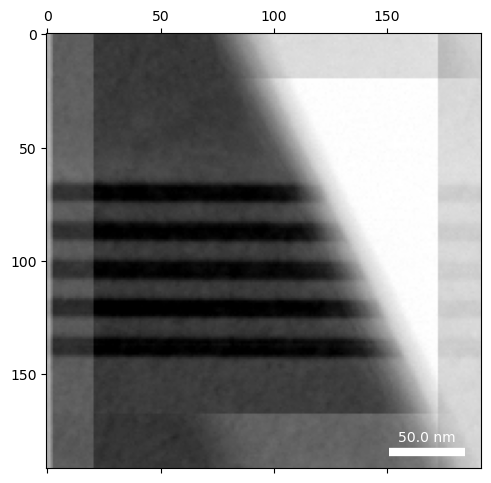

In [32]:
py4DSTEM.show(
    BF,
    scalebar = True,
    pixelsize = dc0.calibration.R_pixel_size/10,
    pixelunits= "nm"
    
)

In [43]:
# crop to overlapping region

dc_combined_cropped = dc_combined.copy()[
        crop_x_max:crop_x_min,
        crop_y_max:crop_y_min,
    ]

In [48]:
# convert to py4DSTEM datacube
dc_combined_save = py4DSTEM.DataCube(
    data = dc_combined_cropped
    
)

In [49]:
# save py4DSTEM datacube 

py4DSTEM.save(
    'dc_combined_BE_23_29.h5',
    dc_combined_save,
    "o"
    
)